In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import cv2

import tensorflow.contrib.slim as slim

In [3]:
import sys

sys.path.append('../')
sys.path.append('../datasets/')
sys.path.append('../nets/')
sys.path.append('../preprocessing/')

import synthtext
synthtext_dataset = synthtext.get_split('test', '/home/mobile/data/synthtext/')

In [4]:
import ssd_vgg_512, ssd_common, np_methods

In [5]:
import ssd_vgg_preprocessing

In [6]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [7]:
net_shape = (512, 512)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
ssd_params = ssd_vgg_512.SSDNet.default_params._replace(num_classes=2)
ssd_net = ssd_vgg_512.SSDNet(ssd_params)
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=None)


# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-104129'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-104129


In [8]:
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(512, 512)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=1, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [9]:
def collision_of_box(box1, box2):
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    
    width1 = x12 - x11
    height1 = y12 - y11
    
    width2 = x22 - x21
    height2 = y22 - y21
    
    union = min(x11, x21), min(y11, y21), max(x12, x22), max(y12, y22)
    
    
    union_width = union[2] - union[0]
    union_height = union[3] - union[1]
    
    return union_width < (width2 + width1) and union_height < (height1 + height2)

def group_box_by_collision(boxes, fn_collison):
    groups = []

    for idx, box in enumerate(boxes):
        b_collision = False

        insect_g = []
        for id_g, group in enumerate(groups):
            for i in group:
                if(fn_collison(boxes[i], box)):
                    group.append(idx)
                    insect_g.append(id_g)
                    b_collision = True
                    break
        remain = [i for i in range(len(groups)) if i not in insect_g]

        if len(insect_g) > 0:
            merges = []
            for g in insect_g:
                merges += groups[g]
            merges = list(set(merges))
            new_groups = [merges]
            for r in remain:
                new_groups.append(groups[r])

            groups = new_groups

        if not b_collision:
            groups.append([idx])
    
    return groups

class CollisionLineMajor(object):
    def __init__(self, line_threshold=1.0):
        self.line_threshold = line_threshold
        
    def __call__(self, box1, box2):
        x11, y11, x12, y12 = box1
        x21, y21, x22, y22 = box2

        height1 = x12 - x11
        width1 = y12 - y11

        height2 = x22 - x21
        width2 = y22 - y21

        union = min(x11, x21), min(y11, y21), max(x12, x22), max(y12, y22)
        insec = max(x11, x21), max(y11, y21), min(x12, x22), min(y12, y22)

        union_height = union[2] - union[0]
        union_width = union[3] - union[1]

        insec_height = insec[2] - insec[0] # x

        # split the 密码区和关键信息区
        return float(union_height) / (height2 + height1) < self.line_threshold

In [10]:
class CollisionColumnMajor(object):
    def __init__(self, threshold=0.5):
        self._threshold = threshold
        
    def __call__(self, box1, box2):
        x11, y11, x12, y12 = box1
        x21, y21, x22, y22 = box2

        height1 = x12 - x11
        width1 = y12 - y11

        height2 = x22 - x21
        width2 = y22 - y21

        union = min(x11, x21), min(y11, y21), max(x12, x22), max(y12, y22)
        insec = max(x11, x21), max(y11, y21), min(x12, x22), min(y12, y22)

        union_height = union[2] - union[0]
        union_width = union[3] - union[1]

        insec_height = insec[2] - insec[0] # x
        insec_width = insec[3] - insec[1]

        return float(insec_width) / (union_width) > self._threshold

In [11]:
import visualization

In [12]:
from invorec import common
from invorec.detector_invoice import DetectorInvoice

detect and compute standard invoice.
finish initialization.


In [13]:
import numpy as np

In [14]:
def y_of_groups(boxes, groups):
    return [np.min(boxes[g], axis=0)[0] for g in groups]
def x_of_groups(boxes, groups):
    return [np.min(boxes[g], axis=0)[1] for g in groups]
def y_of_groups_2(boxes, groups):
    return [np.min(boxes[g], axis=0)[2] for g in groups]

In [15]:
def find_date_anchor(rclasses, rscores, rbboxes):
    threshold = 0.91
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]

    left_top_idx = (boxes[:, 0] < 0.4) & (boxes[:, 1] > 0.6)

    left_top_classes = classes[left_top_idx]
    left_top_scores = scores[left_top_idx]
    left_top_boxes = boxes[left_top_idx]
    
    # sel the top group
    number_area_splitor = CollisionLineMajor(1.3)
    groups = group_box_by_collision(left_top_boxes, number_area_splitor)
    
    ys = y_of_groups(left_top_boxes, groups)
    y_idxs = np.argsort(ys)
    
    
    sel_group_id = y_idxs[0]
    # remove noise group on the top
    for _idx in y_idxs:
        if len(groups[_idx]) > 3:
            sel_group_id = _idx
            break
    
    top_group_classes = left_top_classes[groups[sel_group_id]]
    top_group_scores = left_top_scores[groups[sel_group_id]]
    top_group_boxes = left_top_boxes[groups[sel_group_id]]
    
    date_group_classes = top_group_classes[:]
    date_group_scores = top_group_scores[:]
    date_group_boxes = top_group_boxes[:]
    
    while True:
        date_area_splitor = CollisionLineMajor(0.8)
        groups = group_box_by_collision(date_group_boxes, date_area_splitor)
        ys = y_of_groups_2(date_group_boxes, groups)
        y_idxs = np.argsort(ys)

        sel_group_id = y_idxs[-1]

        date_group_classes = date_group_classes[groups[sel_group_id]]
        date_group_scores = date_group_scores[groups[sel_group_id]]
        date_group_boxes = date_group_boxes[groups[sel_group_id]]
    
        if len(date_group_boxes) < 4:
            break
        else:
            order = np.argsort(date_group_scores)[::-1]
            date_group_classes = date_group_classes[order][:-1]
            date_group_scores = date_group_scores[order][:-1]
            date_group_boxes = date_group_boxes[order][:-1]
            
    anchor_id = np.argmin([box[1] for box in date_group_boxes])
    return [date_group_classes[anchor_id], date_group_scores[anchor_id], date_group_boxes[anchor_id]]

In [16]:
def find_date_location(rclasses, rscores, rbboxes):
    anchor_date = find_date_anchor(rclasses, rscores, rbboxes)
    
    y1, x1, y2, x2 = anchor_date[2]
#     print(anchor_date)
    # collision with anchor_date
    anchor_date[2] = np.array([y1, x1+0.07, y2, x1 + 0.2])
    
    threshold = 0.85
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]
    
    clm = CollisionLineMajor(0.8)
    sel_date = [i for i, box in enumerate(boxes) if clm(box, anchor_date[2]) and collision_of_box(box, anchor_date[2]) and (box[0] < 0.4) and (box[1] > anchor_date[2][1])]
    
    boxes = boxes[sel_date]
    scores = scores[sel_date]
    classes = classes[sel_date]
    
    if len(sel_date) > 2:
        sel = np.argsort(scores)[-2:]
        boxes = boxes[sel]
        scores =scores[sel]
        classes = classes[sel]
    
    date_roi = [np.max(boxes[:, 0]), np.min(boxes[:, 1]), np.max(boxes[:, 2]), np.max(boxes[:,3])]
    
    # the width should be larger than 0.12
    if date_roi[3] - date_roi[1] < 0.12:
        date_roi[1] = date_roi[3] - 0.12 
        
    return np.array(date_roi), np.mean(scores)

In [17]:
def find_code_location(rclasses, rscores, rbboxes):
    threshold = 0.99
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]
    
    sel = (boxes[:, 2] < 0.4) & (boxes[:, 3] < 0.4)
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    anchor_code = np.array([0.13, 0.25, 0.21, 0.33])
    
    sel = [i for i, box in enumerate(boxes) if collision_of_box(box, anchor_code)]
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    roi = [np.min(boxes[:, 0]), np.min(boxes[:, 1]), np.max(boxes[:, 2]), np.max(boxes[:,3])]
    
    if roi[3] - roi[1] < 0.15:
        roi[1] = roi[3] - 0.15
    
    roi[0] -= 0.03
    roi[2] += 0.03
    roi[1] -= 0.01
    roi[3] += 0.01
    
    return np.array(roi), np.mean(scores)

In [18]:
def find_checkcode_location(rclasses, rscores, rbboxes, clip_img, code_roi, DEBUG=True):
    threshold = 0.91
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]
    
    sel = (boxes[:, 2] < 0.7) & (boxes[:, 3] < 0.45)
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    sel = (boxes[:, 0] > code_roi[2]) & (boxes[:, 1] > code_roi[1])
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    order = np.argsort(scores)[::-1]
    
    boxes = boxes[order]
    classes = classes[order]
    scores = scores[order]
  
    start_y = int(code_roi[0] * 300)
    img_checkcode = cv2.cvtColor(clip_img[start_y:150, :450], cv2.COLOR_RGB2GRAY)
    img_checkcode = cv2.GaussianBlur(img_checkcode, (5, 5), 0)
    binary = cv2.Canny(img_checkcode, 10, 30, 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)


    lines = cv2.HoughLines(binary, 1, 1*np.pi/180, 200)
    
    rho,theta = lines[0][0]
    print(theta * 180 / np.pi)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho

    x1 = 0
    y1 = int(a/b * x0 + y0)

    x2 = binary.shape[1]
    y2 = int(-a/b * (x2 - x0) + y0)

    if DEBUG:
        cv2.line(clip_img, (x1,start_y+y1), (x2,start_y+y2), (255, 0, 0))
    
    x1_n = x1 / 900.0
    y1_n = (start_y+y1) / 300.0
    
    x2_n = x2 / 900.0
    y2_n = (start_y+y2) / 300.0
    
    line_dir = np.array([y2_n - y1_n, x2_n - x1_n])
    
    sel = [i for i, box in enumerate(boxes) if np.cross((box[:2] + box[2:])/2 - np.array([y1_n, x1_n]), line_dir) < 0]    
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    sel = (boxes[:, 3] > code_roi[3])
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    order = np.argsort(scores)
    boxes = boxes[order]
    scores = scores[order]
    
    return (boxes[-1], scores[-1]) if len(boxes) else (None, None)

In [19]:
def find_number_location(rclasses, rscores, rbboxes, date_roi):
    threshold = 0.91
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]
    
    anchor_number = np.array([date_roi[0] - 0.03, date_roi[3]- 0.02, date_roi[0]- 0.01, date_roi[3]+0.02])
    
    sel = [i for i, box in enumerate(boxes) if collision_of_box(box, anchor_number)]
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    order = np.argsort(scores)
    boxes = boxes[order]
    scores = scores[order]
    
    if len(boxes) > 0:
        boxes[-1][1] -= 0.02
        boxes[-1][3] +=0.01
        
    return (boxes[-1], scores[-1]) if len(boxes) else (None, None)

In [20]:
def find_amount_location(rclasses, rscores, rbboxes, clip_img, DEBUG=True):
    threshold = 0.95
    sel = rscores > threshold

    boxes = rbboxes[sel]
    classes = rclasses[sel]
    scores = rscores[sel]
    
    count = 0
    while True:
        count += 2
        img_amount = cv2.cvtColor(clip_img[:75+count], cv2.COLOR_RGB2GRAY)
        img_amount = cv2.GaussianBlur(img_amount, (5, 5), 0)
        binary = cv2.Canny(img_amount, 5, 20, 0)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)


        lines = cv2.HoughLines(binary, 1, 1*np.pi/180, 400)
        if lines is not None and len(lines) > 0:
            break
    
    rho,theta = lines[0][0]
    print(theta * 180 / np.pi)
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho

    x1 = 0
    y1 = int(a/b * x0 + y0)

    x2 = binary.shape[1]
    y2 = int(-a/b * (x2 - x0) + y0)

    cv2.line(clip_img, (x1,y1), (x2,y2), (255, 0, 0))
    
    x1_n = float(x1) / clip_img.shape[1]
    y1_n = float(y1) / clip_img.shape[0]
    
    x2_n = float(x2) / clip_img.shape[1]
    y2_n = float(y2) / clip_img.shape[0]
    
    line_dir = np.array([y2_n - y1_n, x2_n - x1_n])
    print(line_dir)
    
    sel = [i for i, box in enumerate(boxes) if np.cross((box[:2] + box[2:])/2 - np.array([y1_n, x1_n]), line_dir) < 0]    
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    sel = boxes[:, 1] > 0.5
    
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    # line group and sel the last group
    clm = CollisionLineMajor(0.8)
    groups = group_box_by_collision(boxes, clm)
    ys = y_of_groups(boxes, groups)
    
    sel = groups[np.argsort(ys)[-1]]
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]

    
    # column group and sel the first group
    ccm = CollisionColumnMajor(0.2)
    groups = group_box_by_collision(boxes, ccm)
    
    xs = x_of_groups(boxes, groups)
    
    sel = groups[np.argsort(xs)[0]]
    boxes = boxes[sel]
    classes = classes[sel]
    scores = scores[sel]
    
    # group the boxes
    roi = [np.min(boxes[:, 0]), np.min(boxes[:, 1]), np.max(boxes[:, 2]), np.max(boxes[:,3])]
    
    roi[0] -= 0.02
    roi[2] += 0.02
    roi[1] -= 0.03
    roi[3] += 0.03
    
    return np.array(roi), np.mean(scores)

In [21]:
class VATFieldsExtractor(object):
    def __init__(self):
        self.amount = [None, None]
    
    def do(self, image):
        width = 900
        ratio = float(width) / image.shape[1]
        img = cv2.resize(image, (width, int(image.shape[0]*ratio)))
        
        self.img = img
        self.lower_image = common.clip_rect(img, (0, 300, width, img.shape[0] - 300))
        self.upper_image = common.clip_rect(img, (0, 0, width, 300))
        
        # amount location 
        rclasses, rscores, rbboxes =  process_image(self.lower_image)
        roi, score = find_amount_location(rclasses, rscores, rbboxes, self.lower_image, DEBUG=False)
        roi[::2]  = ((roi[::2] * self.lower_image.shape[0]) + 300.0)/ img.shape[0]
        self.amount = [roi, score]
        
        rclasses, rscores, rbboxes =  process_image(self.upper_image)

        date_roi, date_score = find_date_location(rclasses, rscores, rbboxes)
        code_roi, code_score = find_code_location(rclasses, rscores, rbboxes)
        checkcode_roi, checkcode_score = find_checkcode_location(rclasses, rscores, rbboxes, 
                                                                 self.upper_image, code_roi, DEBUG=False)
        number_roi, number_score = find_number_location(rclasses, rscores, rbboxes, date_roi)
        
        date_roi[::2] = date_roi[::2] * self.upper_image.shape[0] / img.shape[0]
        code_roi[::2] = code_roi[::2] * self.upper_image.shape[0] / img.shape[0]
        if checkcode_roi is not None:
            checkcode_roi[::2] = checkcode_roi[::2] * self.upper_image.shape[0] / img.shape[0]
        if number_roi is not None:
            number_roi[::2] = number_roi[::2] * self.upper_image.shape[0] / img.shape[0]
        
        self.date = [date_roi, date_score]
        self.code = [code_roi, code_score]
        self.checkcode = [checkcode_roi, checkcode_score]
        self.number = [number_roi, number_score]

In [22]:
dir_name = "/home/mobile/data/strange/"
# dir_name = "../../orientation_detection/data/test/inputs/samsung3700/"

1, _L-qe80ktxUNs6_nFkNObg-v3GRVJS3nEe88UR2RnbX2_Bx9VSNNiXM0Qpan2f3n.jpg
90.0000025045
[ 0.  1.]
90.0000025045


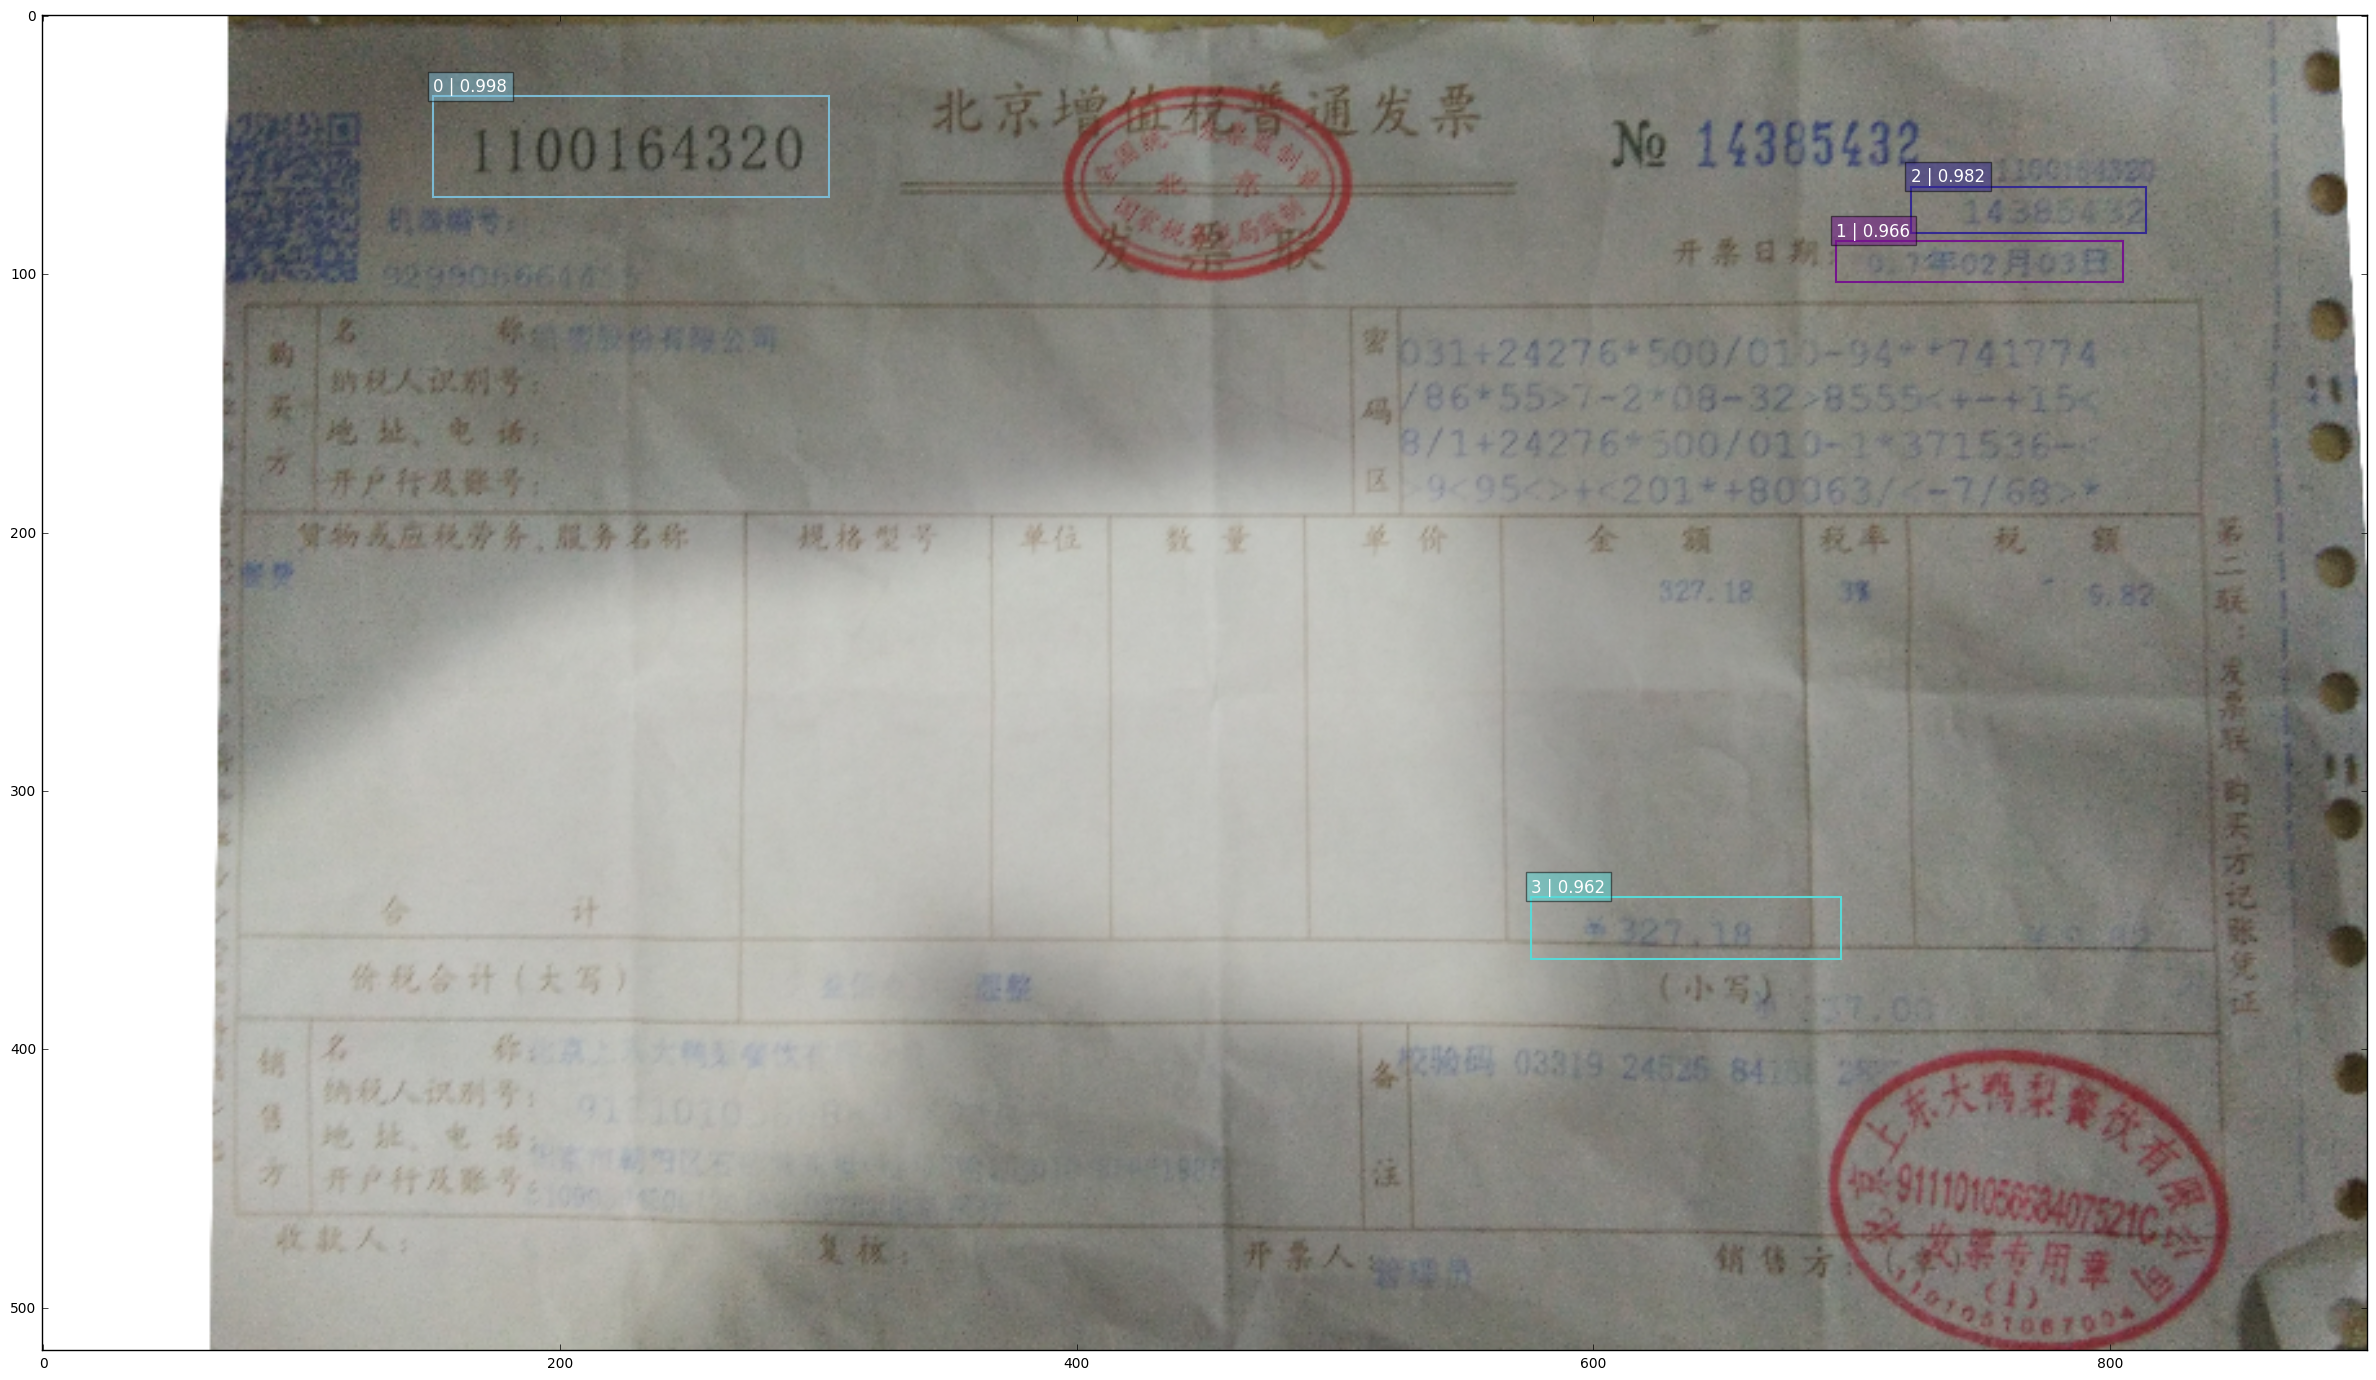

In [23]:
counter = 1
for filename in os.listdir(dir_name)[0:]:
    if os.path.splitext(filename)[1].lower() not in ['.jpg', '.jpeg']:
        print(filename)
        print(os.path.splitext(filename)[1].lower())
        continue
    print("{}, {}".format(counter, filename))
    counter +=1
    path = os.path.join(dir_name, filename)
    cvim = cv2.imread(path)
    cvim = cv2.cvtColor(cvim, cv2.COLOR_BGR2RGB)
    
    invoice_image = DetectorInvoice.done(cvim)
    if invoice_image is not None:
        ve = VATFieldsExtractor()
        ve.do(invoice_image)

        selected_scores = [ve.code[1], ve.date[1], ve.number[1], ve.amount[1]]
        selected_rois = [ve.code[0], ve.date[0], ve.number[0], ve.amount[0]]
        if ve.checkcode[0] is not None:
            selected_scores.append(ve.checkcode[1])
            selected_rois.append(ve.checkcode[0])

        visualization.plt_bboxes(ve.img, np.array(range(len(selected_rois))), 
                                       np.array(selected_scores), 
                                       np.array(selected_rois), 
                                       figsize=(30,30))
    else:
        print('cannot detect invoice')
        plt.figure()
        plt.imshow(cvim)
        plt.show()